In [1]:
require 'cudnn'
require 'inn'
require 'image'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
--image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
image_name='people2.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

timer = torch.Timer()
_,classes = net:forward(I:cuda()):view(-1):float():sort(true)
print('==> Forward Time elapsed: ' .. timer:time().real .. ' seconds')


for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


==> Loading synsets	
==> Loading image and imagenet mean	


==> Preprocessing	


==> Forward Time elapsed: 0.18270182609558 seconds	
predicted class 1: 	guillotine	
predicted class 2: 	restaurant, eating house, eating place, eatery	
predicted class 3: 	lumbermill, sawmill	
predicted class 4: 	bobsled, bobsleigh, bob	
predicted class 5: 	gong, tam-tam	


In [2]:
require'dcnn'

test_net = net:clone()
function ReplaceDualPoolingModule( nn_sequential ) 
    local unpooling_layers = {}
    assert( torch.typename(nn_sequential) == 'nn.Sequential', 'Input should be nn.Sequential()')
    amount_of_poolingLayers = 0
    for i=1, nn_sequential:size() do
        local layer_name = torch.typename(nn_sequential:get(i))
        if layer_name == 'cudnn.SpatialMaxPooling' then
            amount_of_poolingLayers = amount_of_poolingLayers + 1
            local dsmp = dcnn.DualSpatialMaxPooling( nn_sequential:get(i).kW, nn_sequential:get(i).kH, nn_sequential:get(i).dW, 
                                        nn_sequential:get(i).dH, nn_sequential:get(i).padW, nn_sequential:get(i).padH)
            local dsmup = dcnn.DualSpatialMaxUnpooling()
            dsmp:cuda()
            dsmup:cuda()
            dsmup:setDualModule(dsmp)
            nn_sequential.modules[i] = dsmp
            unpooling_layers[amount_of_poolingLayers]=dsmup
        end
    end    
    
    return unpooling_layers
end    

--print(torch.typename(test_net:get(1)))
unpooling_layers = dcnn:ReplaceDualPoolingModule(test_net:get(1))

timer = torch.Timer()
_,classes = test_net:forward(I:cuda()):view(-1):float():sort(true)
print('==> Forward Time elapsed: ' .. timer:time().real .. ' seconds')

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Forward Time elapsed: 0.007997989654541 seconds	
predicted class 1: 	guillotine	
predicted class 2: 	restaurant, eating house, eating place, eatery	
predicted class 3: 	lumbermill, sawmill	
predicted class 4: 	bobsled, bobsleigh, bob	
predicted class 5: 	gong, tam-tam	


In [119]:
print( test_net:get(1))

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> output]
  (1): cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)
  (2): cudnn.ReLU
  (3): inn.SpatialSameResponseNormalization
  (4): dcnn.DualSpatialMaxPooling(3,3,2,2)
  (5): cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)
  (6): cudnn.ReLU
  (7): inn.SpatialSameResponseNormalization
  (8): dcnn.DualSpatialMaxPooling(3,3,2,2)
  (9): cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)
  (10): cudnn.ReLU
  (11): cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)
  (12): cudnn.ReLU
  (13): cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)
  (14): cudnn.ReLU
}
{
  gradInput : CudaTensor - empty
  modules : 
    {
      1 : 
        cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)
        {
          padW : 1
          nInputPlane : 3
          output : CudaTensor - size: 96x110x110
          gradInput : CudaTensor - size: 3x224x224
          iDesc : cdata<str

          dH : 2
          dW : 2
          nOutputPlane : 96
          kW : 7
          extraBufferSizeInBytes : 588
          weight_offset : 14112
          finput : CudaTensor - empty
          padH : 1
          input_offset : 150528
          weight : CudaTensor - size: 96x3x7x7
          train : false
          gradWeight : CudaTensor - size: 96x3x7x7
          fgradInput : CudaTensor - empty
          output_offset : 1161600
          gradBias : CudaTensor - size: 96
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x43eb71a8
        }
      2 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 96x110x110
          gradInput : CudaTensor - empty
          nElem : 1161600
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43cfdd70
        }
      3 : 
        inn.SpatialSameResponseNormalization
        {
          alpha : 5e-05
          train : false


          output : CudaTensor - size: 96x110x110
          gradInput : CudaTensor - empty
          size : 3
          modules : 
            nn.Sequential {
              [input -> (1) -> (2) -> output]
              (1): nn.ConcatTable {
                input
                  |`-> (1): nn.Identity
                  |`-> (2): nn.Sequential {
                  |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> output]
                  |      (1): nn.SpatialZeroPadding(l=1,r=1,t=1,b=1)
                  |      (2): nn.Power
                  |      (3): nn.SpatialAveragePooling(3,3,1,1)
                  |      (4): nn.MulConstant
                  |      (5): nn.AddConstant
                  |      (6): nn.Power
                  |    }
                   ... -> output
              }
              (2): nn.CDivTable
            }
            {
              gradInput : CudaTensor - empty
              modules : 
                {
                  1 : nn.ConcatTable {
  input

          dualModule : 
            dcnn.DualSpatialMaxUnpooling
            {
              gradInput : CudaTensor - empty
              dualModule : 
                dcnn.DualSpatialMaxPooling(3,3,2,2)
                {
                  dH : 2
                  dW : 2
                  padH : 0
                  gradInput : CudaTensor - empty
                  indices : CudaTensor - size: 96x54x54
                  dualModule : dcnn.DualSpatialMaxUnpooling
                  kH : 3
                  output : CudaTensor - size: 96x54x54
                  padW : 0
                  kW : 3
                }
              output : CudaTensor - size: 96x110x110
            }
          kH : 3
          output : CudaTensor - size: 96x54x54
          padW : 0
          kW : 3
    

    }
      5 : 
        cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)
        {
          padW : 0
          nInputPlane : 96
          output : CudaTensor - size: 256x25x25
          gradInput : CudaTensor - size: 96x54x54
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x407605f0
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x40760ad0
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40761440
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40761110
          algType : cdata<enum 761 [?]>: 0x40761778
          extraBuffer : CudaTensor - size: 2400
          biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40760140
          kH : 5
          bias : CudaTensor - size: 256
          groups : 1
          dH : 2
          dW : 2
          nOutputPlane : 256
          kW : 5
          extraBufferSizeInBytes : 9600
          weight_offset : 614400
          finput : CudaTensor - empty
          pad

       fgradInput : CudaTensor - empty
          output_offset : 160000
          gradBias : CudaTensor - size: 256
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x43cfe348
        }
      6 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 256x25x25
          gradInput : CudaTensor - empty
          nElem : 160000
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40762360
        }
      7 : 
        inn.SpatialSameResponseNormalization
        {
          alpha : 5e-05
          train : false
          output : CudaTensor - size: 256x25x25
          gradInput : CudaTensor - empty
          size : 3
          modules : 
            nn.Sequential {
              [input -> (1) -> (2) -> output]
              (1): nn.ConcatTable {
                input
                  |`-> (1): nn.Identity
                  |`-> (2): nn.Sequential {
                  |     

                  1 : nn.ConcatTable {
  input
    |`-> (1): nn.Identity
    |`-> (2): nn.Sequential {
    |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> output]
    |      (1): nn.SpatialZeroPadding(l=1,r=1,t=1,b=1)
    |      (2): nn.Power
    |      (3): nn.SpatialAveragePooling(3,3,1,1)
    |      (4): nn.MulConstant
    |      (5): nn.AddConstant
    |      (6): nn.Power
    |    }
     ... -> output
}
                  2 : nn.CDivTable
                }
              output : CudaTensor - size: 256x25x25
            }
          beta : 0.75
        }
      8 : 
        dcnn.DualSpatialMaxPooling(3,3,2,2)
        {
          dH : 2
          dW : 2
          padH : 0
          gradInput : CudaTensor - empty
          indices : CudaTensor - size: 256x12x12
          dualModule : 
            dcnn.DualSpatialMaxUnpooling
            {
              gradInput : CudaTensor - empty
              dualModule : 
                dcnn.DualSpatialMaxPooling(3,3,2,2)
              

  indices : CudaTensor - size: 256x12x12
                  dualModule : dcnn.DualSpatialMaxUnpooling
                  kH : 3
                  output : CudaTensor - size: 256x12x12
                  padW : 0
                  kW : 3
                }
              output : CudaTensor - size: 256x25x25
            }
          kH : 3
          output : CudaTensor - size: 256x12x12
          padW : 0
          kW : 3
        }
      9 : 
        cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : CudaTensor - size: 384x12x12
          gradInput : CudaTensor - size: 256x12x12
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43d1caf8
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x43d1cfd8
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x43d1d948
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43d1d618
          algType : c

    biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43d1c648
          kH : 3
          bias : CudaTensor - size: 384
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          kW : 3
          extraBufferSizeInBytes : 9216
          weight_offset : 884736
          finput : CudaTensor - empty
          padH : 1
          input_offset : 36864
          weight : CudaTensor - size: 384x256x3x3
          train : false
          gradWeight : CudaTensor - size: 384x256x3x3
          fgradInput : CudaTensor - empty
          output_offset : 55296
          gradBias : CudaTensor - size: 384
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x43d1c2d8
        }
      10 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 384x12x12
          gradInput : CudaTensor - empty
          nElem : 55296
          iDesc : cdata<struct cudnnTensorStruc

  11 : 
        cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : CudaTensor - size: 384x12x12
          gradInput : CudaTensor - size: 384x12x12
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43c44ff8
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x43c454d8
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x43c45e48
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43c45b18
          algType : cdata<enum 761 [?]>: 0x43c5c168
          extraBuffer : CudaTensor - size: 3456
          biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43c44b48
          kH : 3
          bias : CudaTensor - size: 384
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          kW : 3
          extraBufferSizeInBytes : 13824
          weight_offset : 1327104
          finput : CudaTensor - empty
          pa

output_offset : 55296
          gradBias : CudaTensor - size: 384
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x43c447d8
        }
      12 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 384x12x12
          gradInput : CudaTensor - empty
          nElem : 55296
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43c5cd78
        }
      13 : 
        cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : CudaTensor - size: 256x12x12
          gradInput : CudaTensor - size: 384x12x12
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43c5dad0
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x43c5dfb0
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x43e61bd0
          oDesc : cdata<struct cudnnTensorStruct 

   dH : 1
          dW : 1
          nOutputPlane : 256
          kW : 3
          extraBufferSizeInBytes : 13824
          weight_offset : 884736
          finput : CudaTensor - empty
          padH : 1
          input_offset : 55296
          weight : CudaTensor - size: 256x384x3x3
          train : false
          gradWeight : CudaTensor - size: 256x384x3x3
          fgradInput : CudaTensor - empty
          output_offset : 36864
          gradBias : CudaTensor - size: 256
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x43c5d2b0
        }
      14 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 256x12x12
          gradInput : CudaTensor - empty
          nElem : 36864
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x43e62b18
        }
    }
  train : false
  output : CudaTensor - size: 256x12x12
}


==> Scatter Time elapsed: 6.3896179199219e-05 seconds	


==> Deconv Time elapsed: 0.053112030029297 seconds	


==> Scatter Time elapsed: 1.3113021850586e-05 seconds	


==> Deconv Time elapsed: 0.00079512596130371 seconds	


==> Scatter Time elapsed: 8.8214874267578e-06 seconds	


==> Deconv Time elapsed: 0.00081110000610352 seconds	


==> Scatter Time elapsed: 0.020595073699951 seconds	


==> Deconv Time elapsed: 0.00085783004760742 seconds	


==> Scatter Time elapsed: 0.075827121734619 seconds	


==> Deconv Time elapsed: 0.0009300708770752 seconds	


==> Time elapsed: 0.39075613021851 seconds	


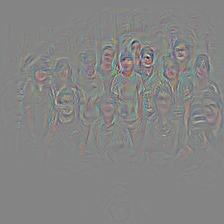

In [3]:
deconv_timer = torch.Timer()
conv5_fm = net:get(1):get(13).output
deconv5 = cudnn.SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 )
conv4_fm_c5 = deconv5:forward(conv5_fm)
conv4_fm_c5 = cudnn.ReLU(true):forward(conv4_fm_c5)

deconv4 = cudnn.SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true )
conv3_fm_c5 = deconv4:forward(conv4_fm_c5[1])
conv3_fm_c5 = cudnn.ReLU(true):forward(conv3_fm_c5)

deconv3 = cudnn.SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true )
pool2_fm_c5 = deconv3:forward(conv3_fm_c5)

--unpool2 = cudnn.SpatialUnPooling(net:get(1):get(8), net:get(1):get(7).output )
unpool2 = unpooling_layers[2]
conv2_fm_c5 = unpool2:forward(pool2_fm_c5)
conv2_fm_c5 = cudnn.ReLU(true):forward(conv2_fm_c5)

deconv2 = cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true )
pool1_fm_c5 = deconv2:forward(conv2_fm_c5)

--unpool1 = cudnn.SpatialUnPooling(net:get(1):get(4), net:get(1):get(3).output )
unpool1 = unpooling_layers[1]
conv1_fm_c5 = unpool1:forward(pool1_fm_c5)
conv1_fm_c5 = cudnn.ReLU(true):forward(conv1_fm_c5)

deconv1 = cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true )
vis_c5 = deconv1:forward(conv1_fm_c5)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)


 96
 55
 55
[torch.LongStorage of size 3]


 96
 55
 55
[torch.LongStorage of size 3]



==> Scatter Time elapsed: 0.12676692008972 seconds	


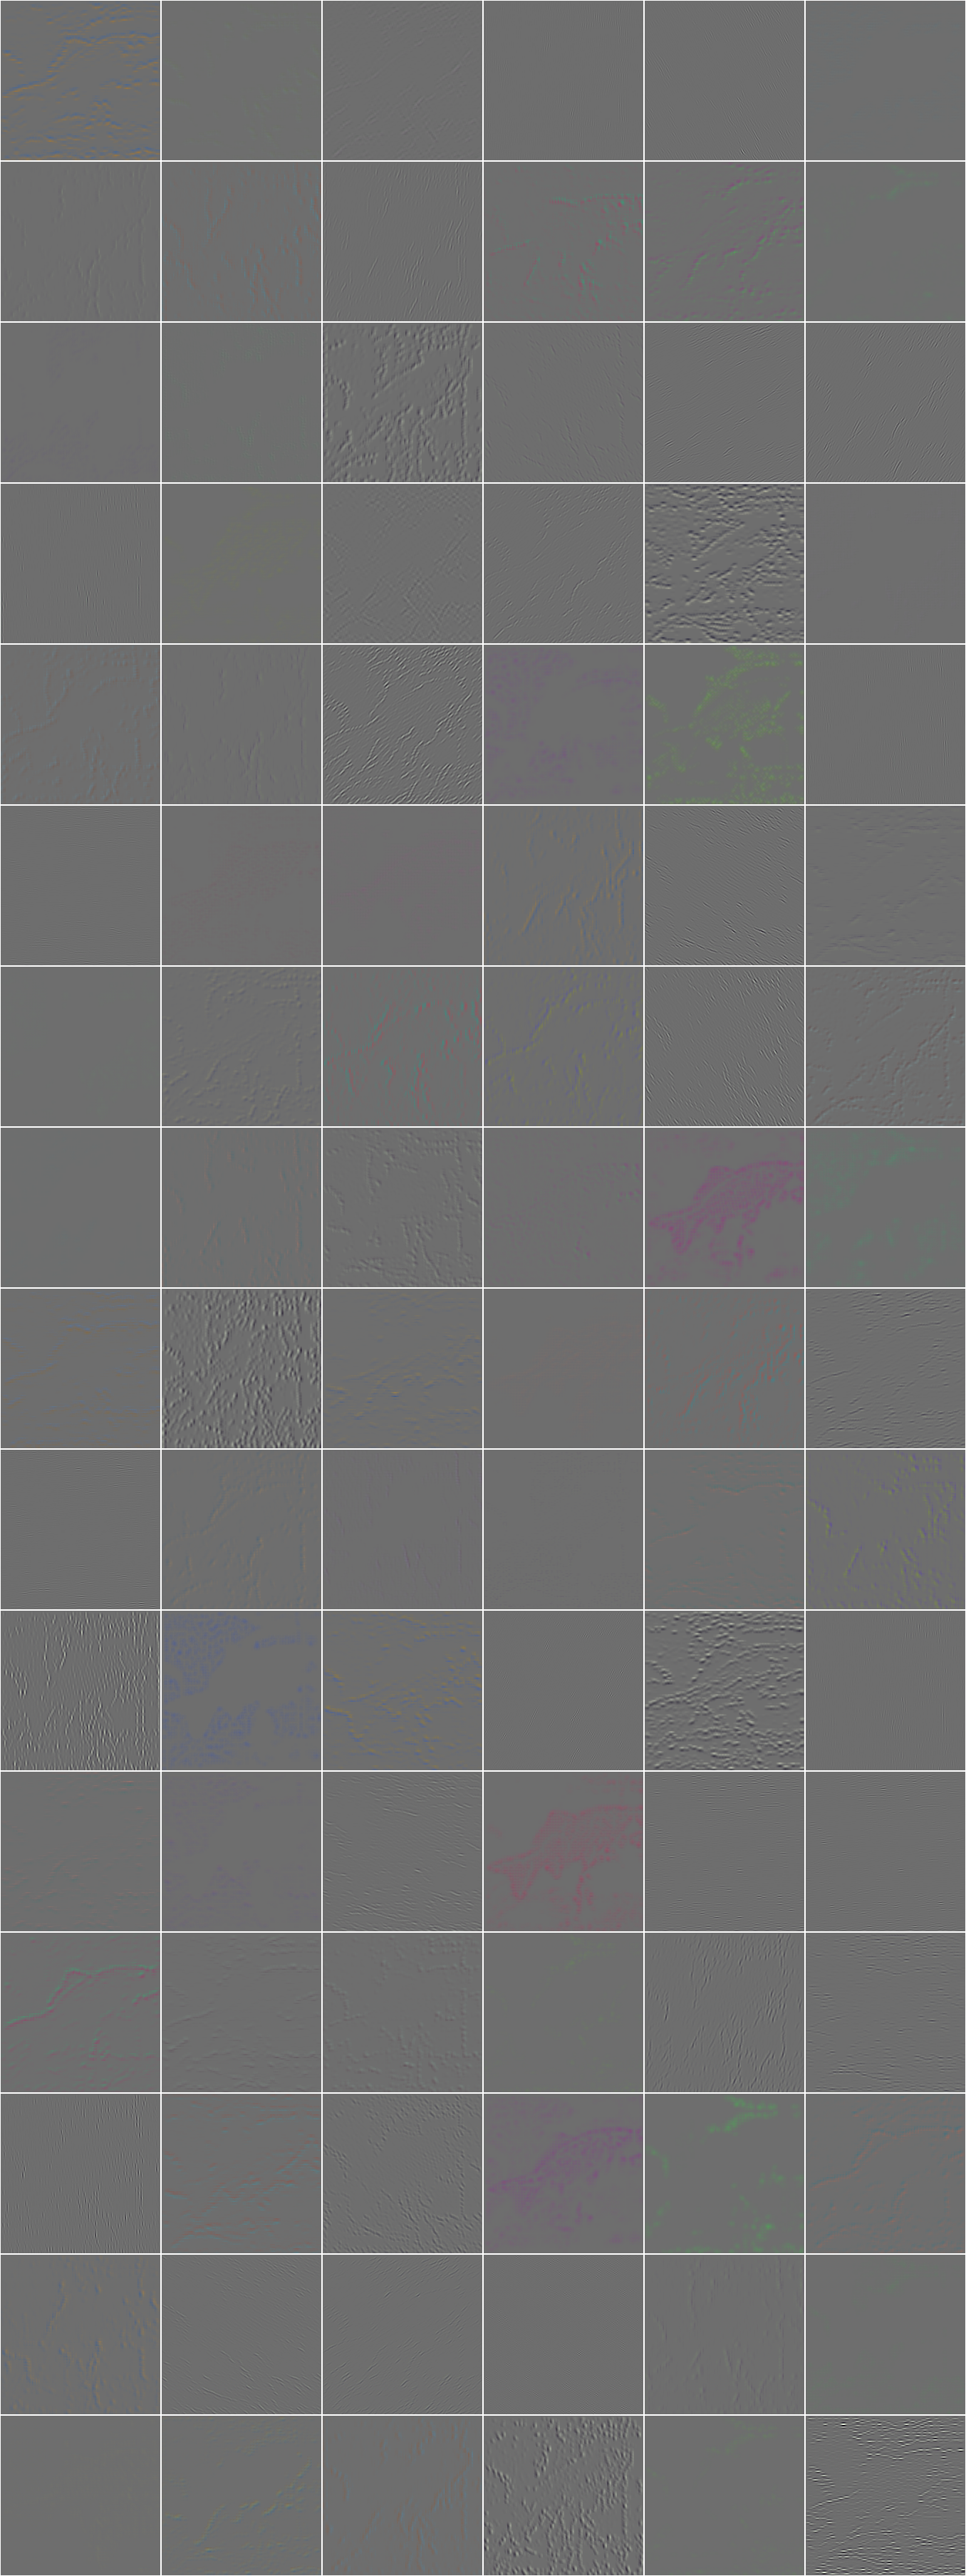

In [3]:
pool1_fm = net:get(1):get(4).output
pool1_fm_t = test_net:get(1):get(4).output
print( pool1_fm:size() )
print( pool1_fm_t:size() )



unpool1 = unpooling_layers[1]
conv1_fm = unpool1:forward(pool1_fm)
conv1_fm = cudnn.ReLU(true):forward(conv1_fm)

deconv1 = cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2) )
vis_p1 = deconv1:forward(conv1_fm)
itorch.image(vis_p1)

==> Scatter Time elapsed: 0.078160047531128 seconds	


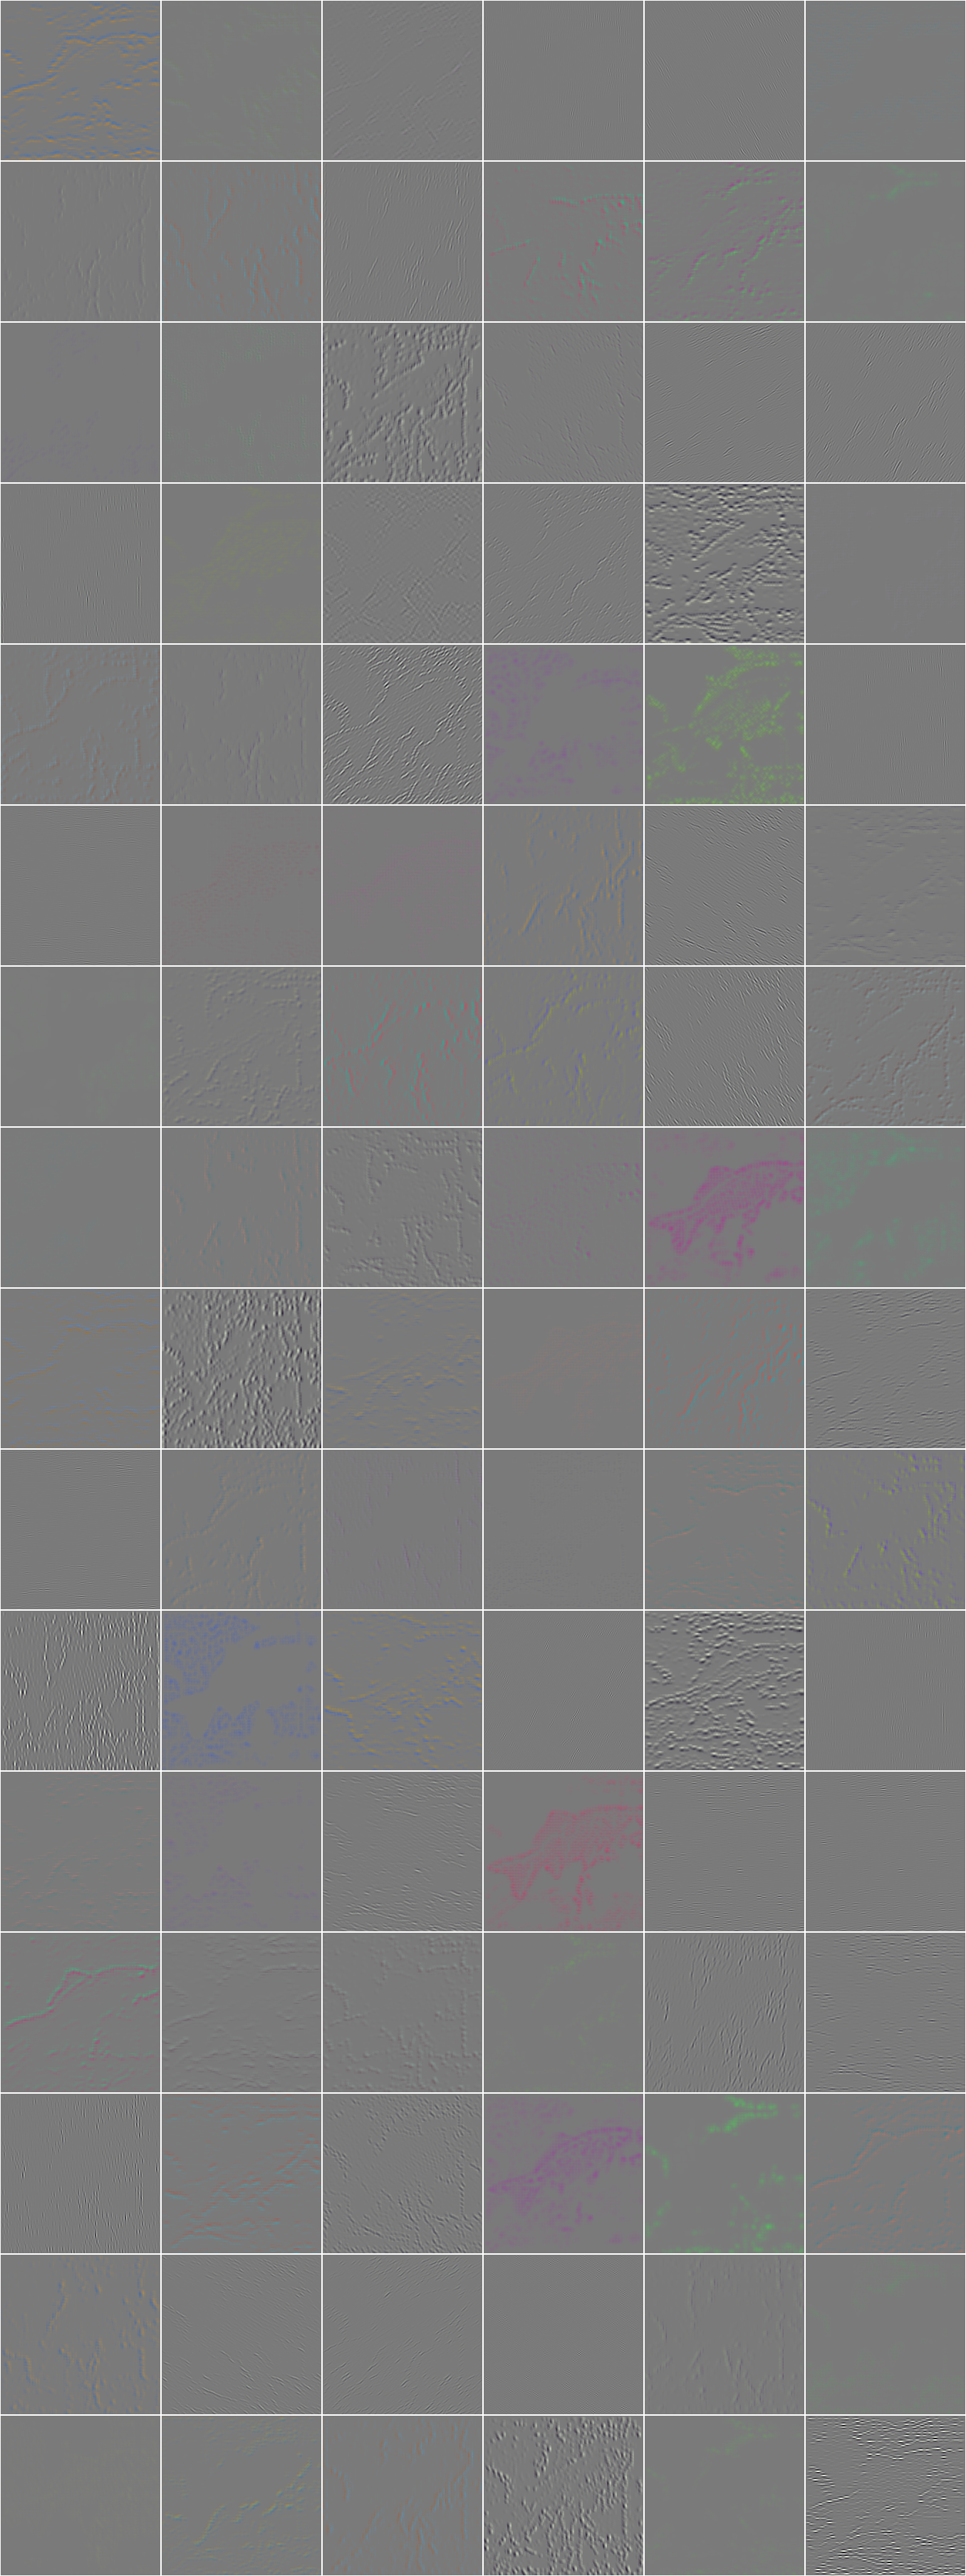

In [4]:
unpool1 = cudnn.SpatialUnPooling( net:get(1):get(4), net:get(1):get(3).output )
--unpool1 = unpooling_layers[1]
conv1_fm = unpool1:forward(pool1_fm)
conv1_fm = cudnn.ReLU(true):forward(conv1_fm)

deconv1 = cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2) )
vis_p1 = deconv1:forward(conv1_fm)
itorch.image(vis_p1)